In [17]:
!pip install geopandas
!pip install cartopy

     |████████████████████████████████| 10.8 MB 28.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 23.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 22.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 50.5 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516271 sha256=d80be547614e28f272e85033ed20dbddb638e59bf4fc7f45a65b4c919186f4ee
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=baa63235b750d5e2741517f918eff4d7205fd766bc2c899d0d6df203b227a120
  Stored in directory: /root/.cac

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sb
import numpy as np

import geopandas as gpd
import folium

from scipy import stats

import shapely

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [3]:
df = pd.read_csv('US_MaizeYield Predictors_1950-2013.csv')

In [4]:
df.index = pd.to_datetime(df.year, format='%Y')
df['state'] = df['state'].astype(int)
df_states =  pd.read_csv('states.csv', header=0, 
                         names=['name', 'zip', 'FIPS'])
st_dict = { int(row['FIPS']): row['zip'] for index, row in df_states.iterrows()}
df['state'] = df['state'].map(st_dict)

In [5]:
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData.STATE.isin(stateToRemove)]

In [6]:
# We import the geoJSON file. 
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/us-states.json"
# We read the file and print it.
geoJSON_df = gpd.read_file(state_geo)
geoJSON_df = geoJSON_df.rename(columns = {"id":"state"})
geoJSON_df.head()

,state,name,geometry
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [7]:
final_df = geoJSON_df.merge(df, on ="state")
final_df.head(2)

,state,name,geometry,yield,year,fips,area,EDD_4,GDD_4,prcp_4,SM_mean_4,SM_week_max_4,SM_week_min_4,SM_mean2_4,prcp2_4,EDD_5,GDD_5,prcp_5,SM_mean_5,SM_week_max_5,SM_week_min_5,SM_mean2_5,prcp2_5,EDD_6,GDD_6,prcp_6,SM_mean_6,SM_week_max_6,SM_week_min_6,SM_mean2_6,prcp2_6,EDD_7,GDD_7,prcp_7,SM_mean_7,SM_week_max_7,SM_week_min_7,SM_mean2_7,prcp2_7,EDD_8,GDD_8,prcp_8,SM_mean_8,SM_week_max_8,SM_week_min_8,SM_mean2_8,prcp2_8,EDD_9,GDD_9,prcp_9,SM_mean_9,SM_week_max_9,SM_week_min_9,SM_mean2_9,prcp2_9,maize_irr_frac
0,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",182.2,2013.0,1033,25500.0,0.144660,182.989896,138.405888,30.587954,31.415827,30.061306,941.999898,19333.677294,2.140415,307.845005,129.992978,29.244037,31.925165,27.977068,860.303639,16966.031939,15.901134,438.528011,102.425542,28.345804,30.798655,24.423257,809.207257,10500.088267,11.920542,456.185492,183.840496,29.832954,31.353337,28.232217,898.043844,35385.660239,16.034756,457.816776,126.349092,28.992069,32.38172,27.690612,848.933193,16804.874644,12.602523,388.188638,96.585943,27.869618,29.376769,25.102011,781.745164,9666.466330,0.119278
1,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",102.4,2012.0,1033,24500.0,0.444557,226.509776,39.489620,26.918694,30.273795,24.639479,730.920612,1613.068087,10.229904,381.640335,102.801898,28.099729,31.726761,24.807535,798.927471,10854.030094,29.706318,407.929159,41.418904,25.227545,29.856153,22.629193,643.269072,1787.107896,55.149480,506.288732,150.818249,26.525931,33.543850,18.522075,710.889904,22994.199726,23.369527,462.770254,79.330313,27.629490,30.41856,26.194190,769.387472,6367.565199,6.820552,355.923101,152.952440,28.802978,30.817406,25.627490,834.572860,23509.203313,0.119278


In [8]:
ill_df = final_df.where(final_df['state'] == 'IL').dropna()
ill_df.index = pd.to_datetime(ill_df.year, format='%Y')

ill_df['total_prcp'] = ill_df['prcp_4'] + ill_df['prcp_5'] + ill_df['prcp_6'] + ill_df['prcp_7'] + ill_df['prcp_8'] + ill_df['prcp_9']

In [9]:
final_df['total_prcp'] = final_df['prcp_4'] + final_df['prcp_5'] + final_df['prcp_6'] + final_df['prcp_7'] + final_df['prcp_8'] + final_df['prcp_9']

In [10]:
final_df.index = pd.to_datetime(final_df.year, format='%Y')
states_df = final_df.groupby(['state'])


#data_train, data_test = train_test_split(states_df, train_size=0.8)
county_df = final_df.groupby(['fips'])

In [13]:
r2 = {}
rmse = {}

for group in county_df.groups.keys():
  df = county_df.get_group(group)
  x_a = df['year']
  x_b = df['total_prcp']


  y = df['yield']
  if len(y) > 30:
    x2 = sm.add_constant(np.transpose([x_a,x_b]))

    mod_multi = sm.OLS(y,x2).fit()
    
    y_pred_multi = mod_multi.fittedvalues

    # print(np.str(group))
    # print(mod_multi.summary())
    
    # print(np.str(group)+ ' R^2 = ',mod_multi.rsquared)

    rmse_err_multi = mean_squared_error(y, y_pred_multi,squared=False)
    # print(np.str(group)+ ' RMSE = ',rmse_err_multi)

    r2.update({group : mod_multi.rsquared})
    rmse.update({group : rmse_err_multi})

    
    # fig, ax = plt.subplots(figsize=(10,5))
    # ax.hist(y-y_pred_multi,density=True)
    # ax.set_xlabel('Residual')
    # ax.set_ylabel('Frequency')
    # ax.set_title('Residuals:' + np.str(group))

    # mu, std=stats.norm.fit(y-y_pred_multi)
    # x_vals= np.linspace(stats.norm.ppf(0.01,mu,std),
    #               stats.norm.ppf(0.99,mu,std), 100)

    # ax.plot(x_vals, stats.norm.pdf(x_vals,mu,std),
    #           'k-', lw=5, alpha=0.6, label='gaussian pdf')
    # plt.show()

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


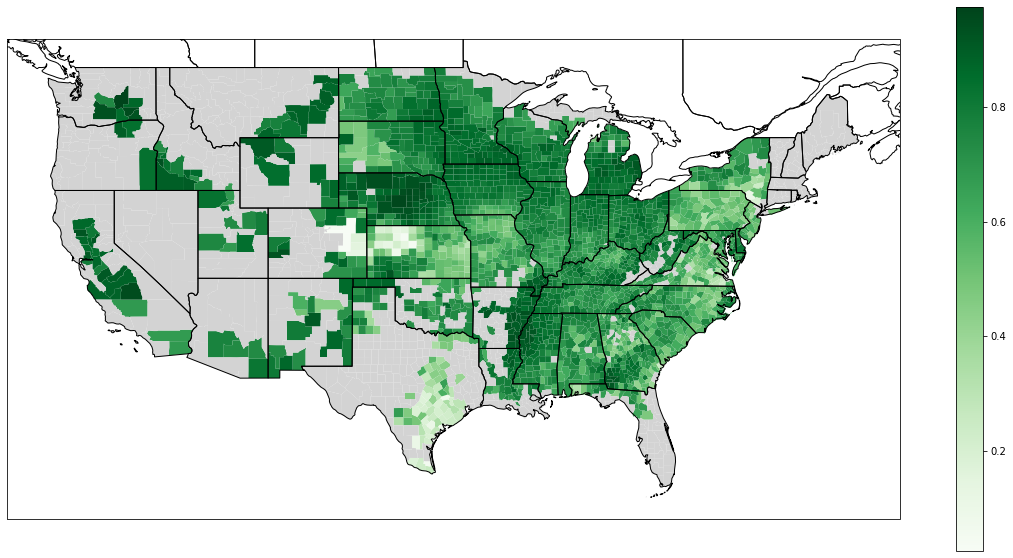

In [19]:
df_results = pd.DataFrame.from_dict(r2, orient='index', columns = ['R2']).reset_index()
df_results = pd.merge(geoData, df_results, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

df_results.plot(column = 'R2', ax=ax, legend=True, cmap = 'Greens', missing_kwds={'color': 'lightgrey'})
ax.add_feature(cfeature.STATES)

plt.show()

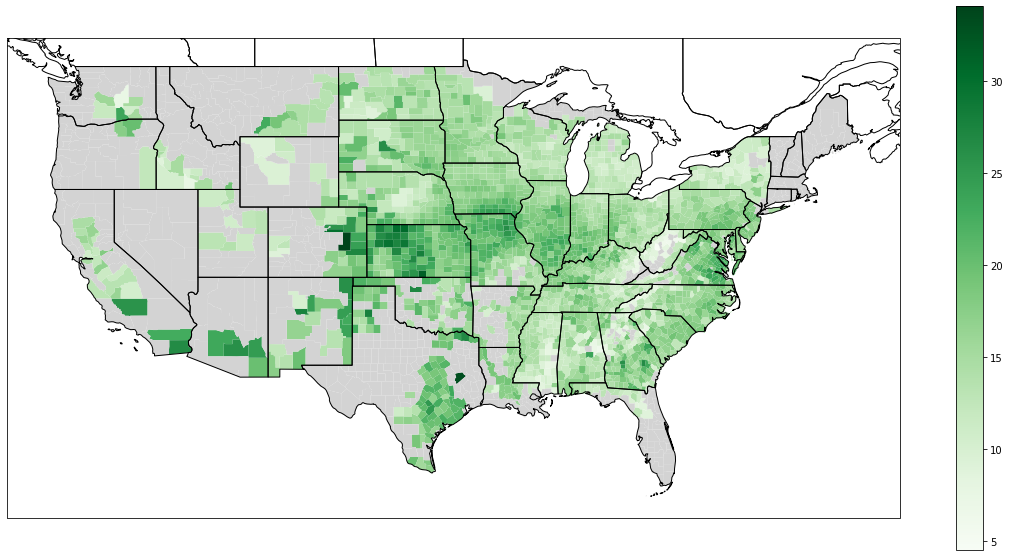

In [20]:
df_rmse = pd.DataFrame.from_dict(rmse, orient='index', columns = ['RMSE']).reset_index()
df_rmse = pd.merge(geoData, df_rmse, right_on = 'index', left_on = 'id', how='outer')

# Plot R2
fig, ax = plt.subplots(figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

df_rmse.plot(column = 'RMSE', ax=ax, legend=True, cmap = 'Greens', missing_kwds={'color': 'lightgrey'})
ax.add_feature(cfeature.STATES)

plt.show()

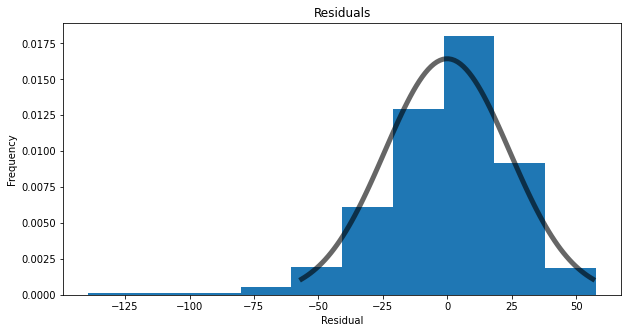

In [ ]:
# Histogram of residuals! 

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(y-y_pred_multi,density=True)
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')
ax.set_title('Residuals')

mu, std=stats.norm.fit(y-y_pred_multi)
x_vals= np.linspace(stats.norm.ppf(0.01,mu,std),
               stats.norm.ppf(0.99,mu,std), 100)

ax.plot(x_vals, stats.norm.pdf(x_vals,mu,std),
          'k-', lw=5, alpha=0.6, label='gaussian pdf')
plt.show()

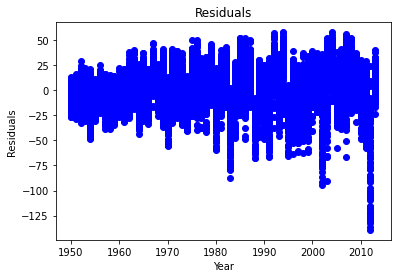

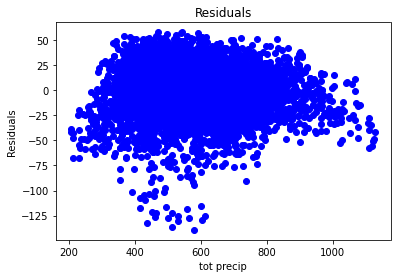

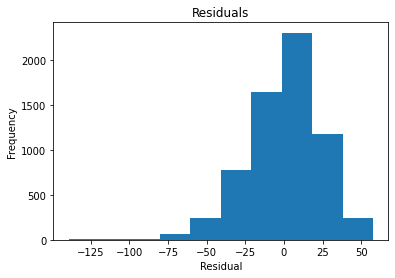

In [ ]:
# Plot residuals - each predictor individually, yes?

# Residuals for flipper length
fig,ax=plt.subplots()
ax.scatter(x_a,y-y_pred_multi,color='b')
ax.set_xlabel('Year')
ax.set_ylabel('Residuals')
ax.set_title('Residuals')
plt.show()


# Residuals for bill length
fig,ax=plt.subplots()
ax.scatter(x_b,y-y_pred_multi,color='b')
ax.set_xlabel('tot precip')
ax.set_ylabel('Residuals')
ax.set_title('Residuals')
plt.show()


# Histogram for residuals
fig, ax = plt.subplots()
ax.hist(y-y_pred_multi)
ax.set_xlabel('Residual')
ax.set_ylabel('Frequency')
ax.set_title('Residuals')
plt.show()

In [ ]:
states_df['total_prcp'].boxplot()

AttributeError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(x_a, x_b)

In [ ]:
ill_corr = ill_df.corr()
mask = np.triu(np.ones_like(ill_corr, dtype=bool))

fig, ax = plt.subplots(figsize=(15,15))

cmap = 'coolwarm'

sb.heatmap(ill_corr,mask=mask, annot=False, fmt='.2f', cmap=cmap, vmin=-1, vmax=1, square=True, linewidth=.7)

In [ ]:
# fmap = folium.Map(location=[38, -102], zoom_start=4)


# folium.Choropleth(
#                   geo_data=final_df,
#                   data=final_df,
#                   columns=['state',"prcp_9"],
#                   key_on="feature.properties.state",
#                   fill_color='YlGnBu',
#                   fill_opacity=1,
#                   line_opacity=0.2,
#                   legend_name="prcp_9",
#                   smooth_factor=0,
#                   Highlight= True,
#                   line_color = "#0000",
#                   name = "Wills",
#                   show=False,
#                   overlay=True,
#                   nan_fill_color = "White"
#                   ).add_to(fmap)



/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


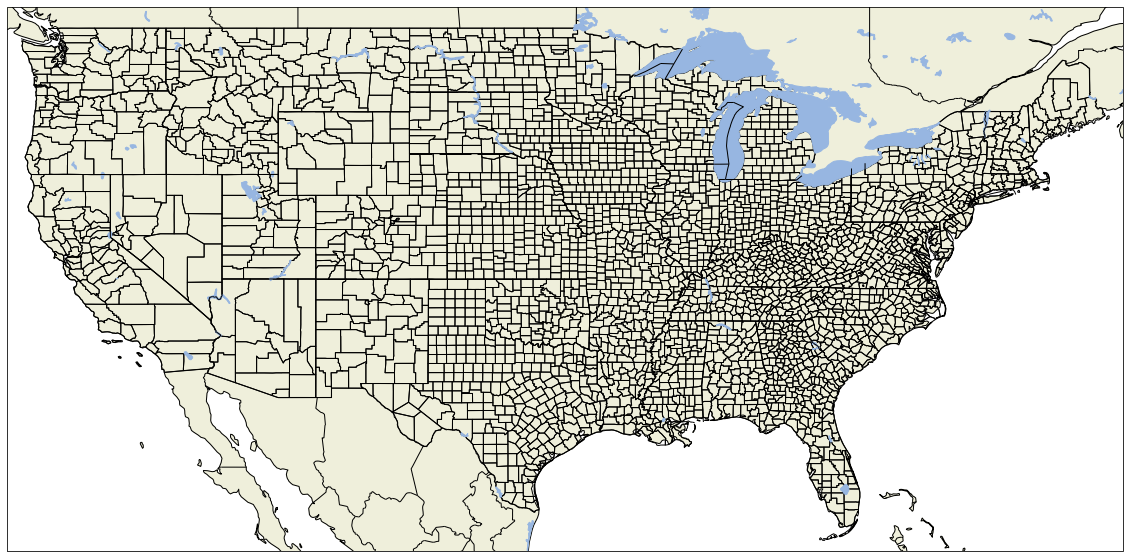

In [ ]:
fig, ax = plt.subplots(figsize=(20,10), subplot_kw=dict(projection=ccrs.PlateCarree()))

states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', scale='10m', facecolor='none')
 
ax.set_extent([-125.5, -66,24,50], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(USCOUNTIES)
ax.add_feature(cfeature.LAKES)
ax.add_feature(states_provinces, edgecolor='black')
ax.set_aspect('auto') #handy to get the cbar to match the plot